# Heart Disease Data Preprocessing

This notebook handles:
1. Exploratory Data Analysis (EDA)
2. Missing Value Analysis & Imputation
3. Feature Engineering
4. Data Preparation for Binary & Multi-class Classification
5. Class Imbalance Handling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
import warnings
import pickle

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Initial Exploration

In [2]:
# Load dataset
df = pd.read_csv('../data/raw/heart_disease_uci.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset Shape: (920, 16)

Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
# Data types and info
print("Data Types:")
print(df.dtypes)
print("\nDataset Info:")
df.info()

Data Types:
id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null

Missing Values Summary:
          Missing_Count  Missing_Percentage
ca                  611           66.413043
thal                486           52.826087
slope               309           33.586957
fbs                  90            9.782609
oldpeak              62            6.739130
trestbps             59            6.413043
exang                55            5.978261
thalch               55            5.978261
chol                 30            3.260870
restecg               2            0.217391


<Figure size 1000x600 with 0 Axes>

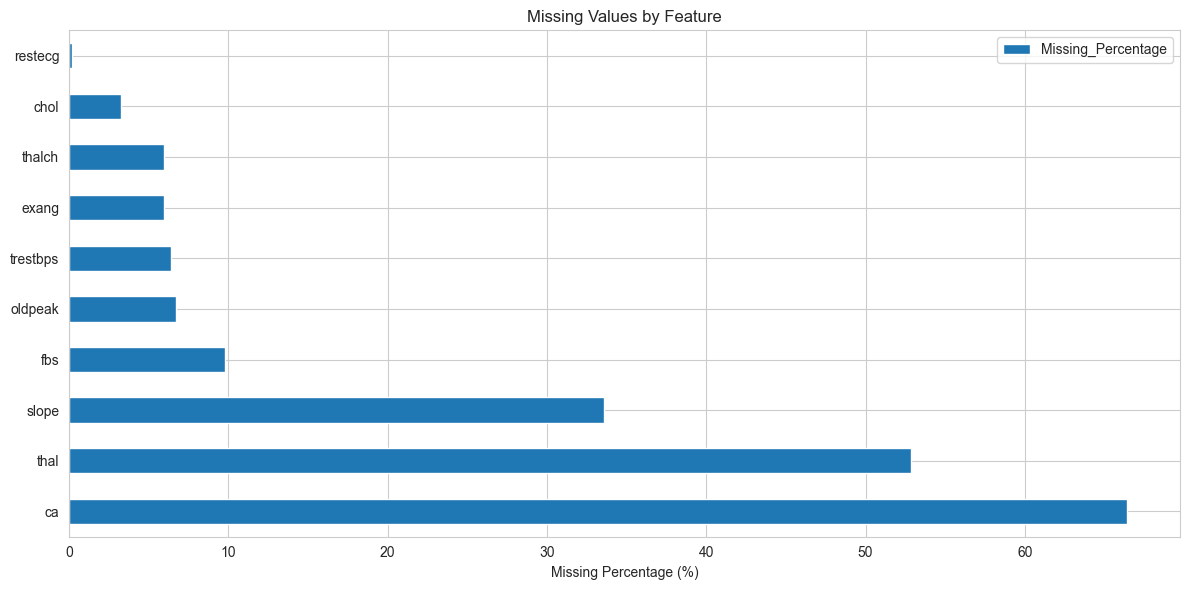

In [4]:
# Missing values analysis
missing_data = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Values Summary:")
print(missing_data[missing_data['Missing_Count'] > 0])

# Visualize missing data
plt.figure(figsize=(10, 6))
missing_data[missing_data['Missing_Count'] > 0].plot(kind='barh', y='Missing_Percentage')
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Values by Feature')
plt.tight_layout()
plt.show()

## 2. Target Variable Analysis

In [5]:
# Clean target variable - remove the single 'num' string value
df_clean = df[df['num'] != 'num'].copy()
df_clean['num'] = df_clean['num'].astype(int)

print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"\nTarget Variable Distribution:")
print(df_clean['num'].value_counts().sort_index())
print(f"\nTarget Variable Percentages:")
print(df_clean['num'].value_counts(normalize=True).sort_index() * 100)

Cleaned dataset shape: (920, 16)

Target Variable Distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Target Variable Percentages:
num
0    44.673913
1    28.804348
2    11.847826
3    11.630435
4     3.043478
Name: proportion, dtype: float64


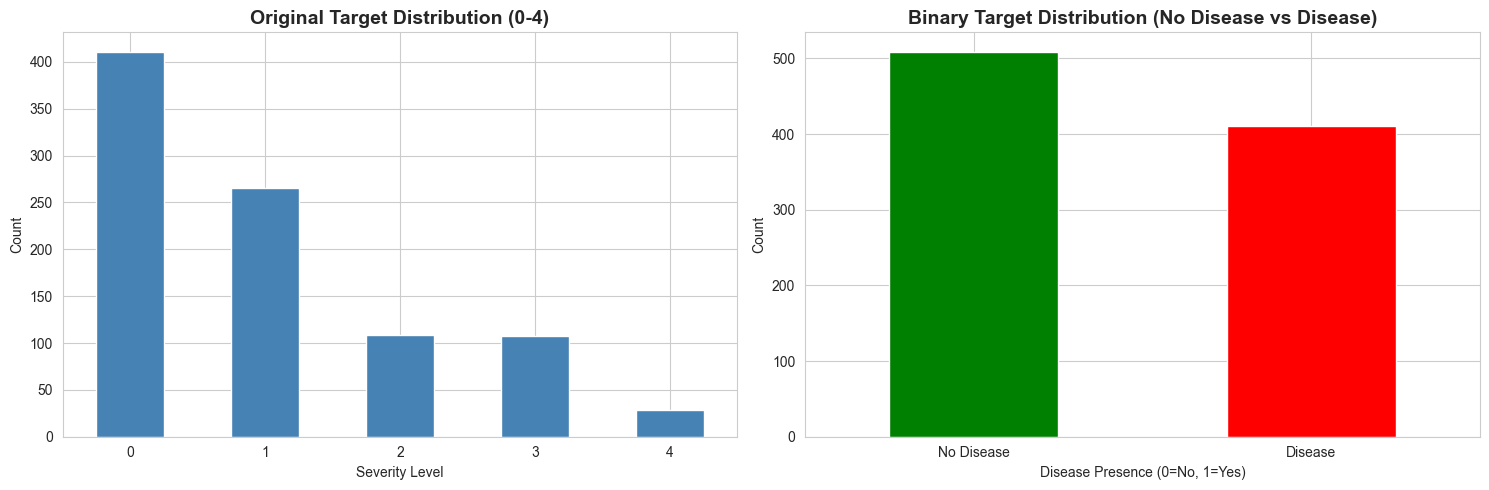


Binary Classification Distribution:
No Disease (0): 411 (44.7%)
Disease (1-4): 509 (55.3%)


In [6]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original multi-class distribution
df_clean['num'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Original Target Distribution (0-4)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Severity Level')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Binary classification distribution
binary_target = (df_clean['num'] > 0).astype(int)
binary_target.value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('Binary Target Distribution (No Disease vs Disease)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Disease Presence (0=No, 1=Yes)')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No Disease', 'Disease'], rotation=0)

plt.tight_layout()
plt.show()

print(f"\nBinary Classification Distribution:")
print(f"No Disease (0): {(binary_target == 0).sum()} ({(binary_target == 0).sum()/len(binary_target)*100:.1f}%)")
print(f"Disease (1-4): {(binary_target == 1).sum()} ({(binary_target == 1).sum()/len(binary_target)*100:.1f}%)")

## 3. Feature Analysis and Type Conversion

In [7]:
# Define feature types based on domain knowledge
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
identifier_features = ['id', 'dataset']

print("Feature Categories:")
print(f"Numeric: {numeric_features}")
print(f"Categorical: {categorical_features}")
print(f"Identifiers (to drop): {identifier_features}")

Feature Categories:
Numeric: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Categorical: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Identifiers (to drop): ['id', 'dataset']


In [8]:
# Convert numeric features to appropriate types
df_processed = df_clean.copy()

for col in numeric_features:
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

# Convert categorical features
for col in categorical_features:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].astype(str)

print("Data types after conversion:")
print(df_processed.dtypes)

Data types after conversion:
id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
num           int64
dtype: object


In [9]:
# Numeric features statistics
print("Numeric Features Statistics:")
print(df_processed[numeric_features].describe())

Numeric Features Statistics:
              age    trestbps        chol      thalch     oldpeak
count  920.000000  861.000000  890.000000  865.000000  858.000000
mean    53.510870  132.132404  199.130337  137.545665    0.878788
std      9.424685   19.066070  110.780810   25.926276    1.091226
min     28.000000    0.000000    0.000000   60.000000   -2.600000
25%     47.000000  120.000000  175.000000  120.000000    0.000000
50%     54.000000  130.000000  223.000000  140.000000    0.500000
75%     60.000000  140.000000  268.000000  157.000000    1.500000
max     77.000000  200.000000  603.000000  202.000000    6.200000


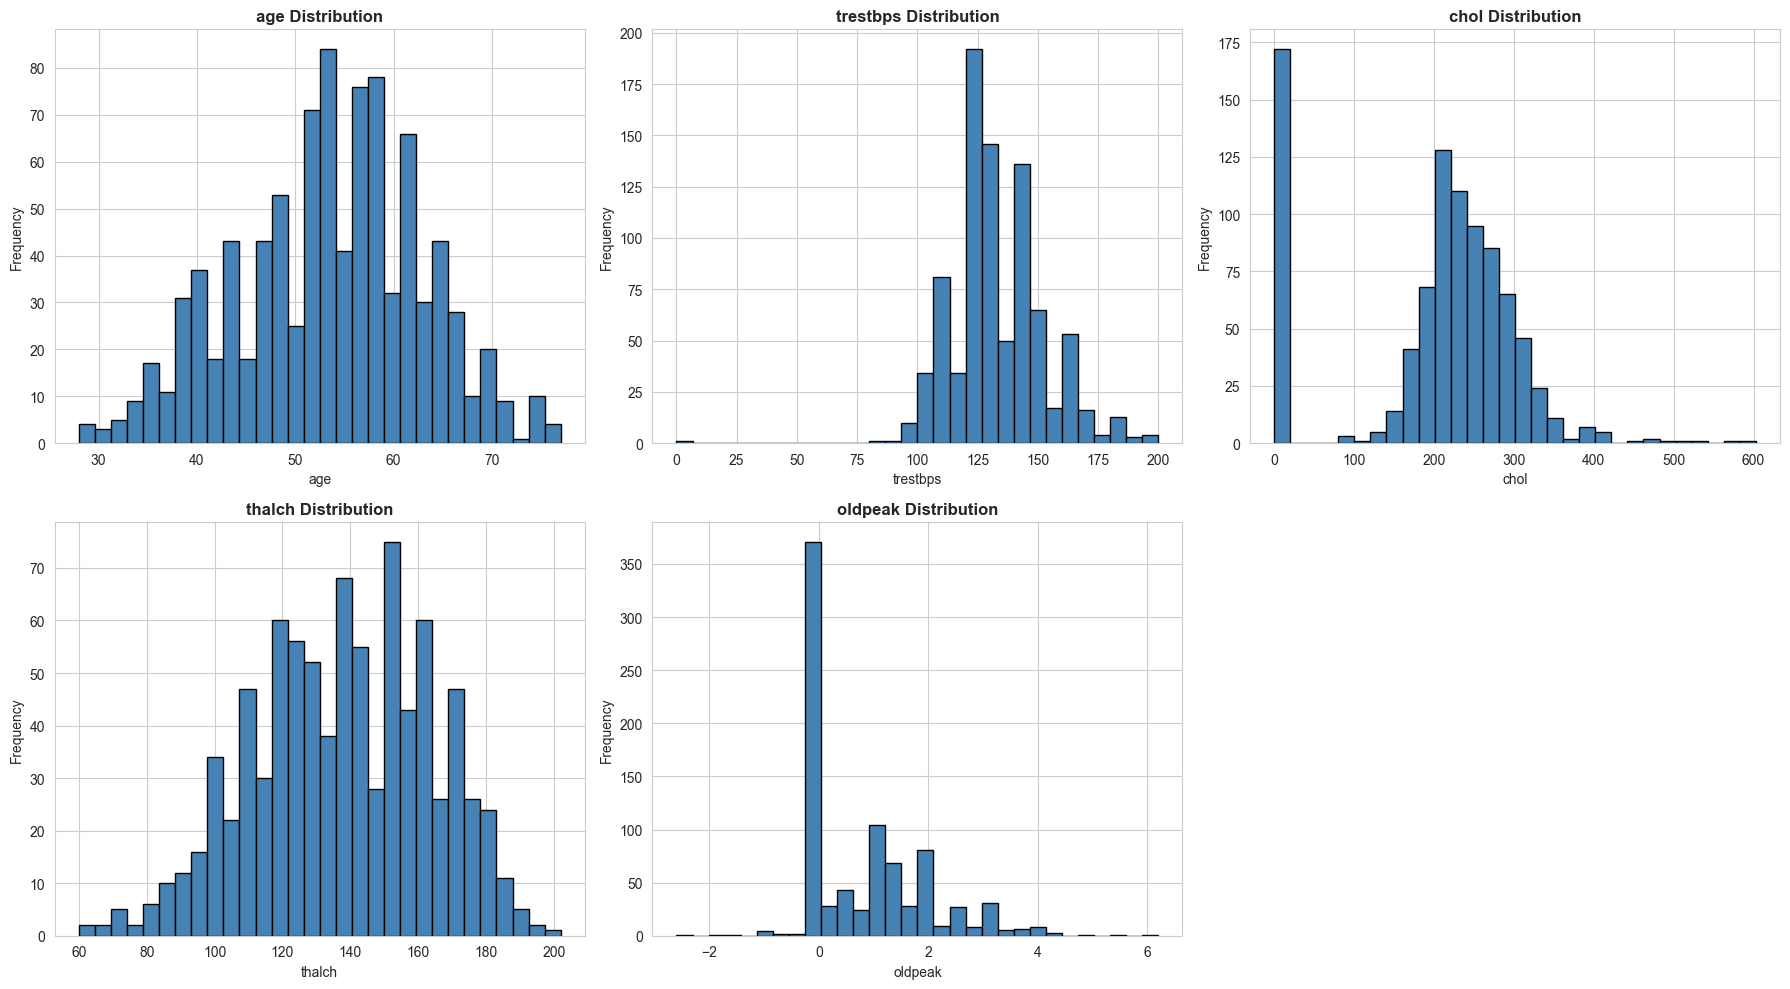

In [10]:
# Visualize numeric feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_features):
    df_processed[col].hist(bins=30, ax=axes[idx], color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{col} Distribution', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

# Remove extra subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [11]:
# Categorical features value counts
print("Categorical Features Value Counts:")
for col in categorical_features:
    if col in df_processed.columns:
        print(f"\n{col}:")
        print(df_processed[col].value_counts())

Categorical Features Value Counts:

sex:
sex
Male      726
Female    194
Name: count, dtype: int64

cp:
cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64

fbs:
fbs
False    692
True     138
nan       90
Name: count, dtype: int64

restecg:
restecg
normal              551
lv hypertrophy      188
st-t abnormality    179
nan                   2
Name: count, dtype: int64

exang:
exang
False    528
True     337
nan       55
Name: count, dtype: int64

slope:
slope
flat           345
nan            309
upsloping      203
downsloping     63
Name: count, dtype: int64

ca:
ca
nan    611
0.0    181
1.0     67
2.0     41
3.0     20
Name: count, dtype: int64

thal:
thal
nan                  486
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64


## 4. Missing Value Imputation Strategy

In [12]:
# Analyze missingness patterns
print("Missing Value Analysis by Feature:")
for col in df_processed.columns:
    missing_count = df_processed[col].isnull().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(df_processed)) * 100
        print(f"{col}: {missing_count} ({missing_pct:.2f}%)")

Missing Value Analysis by Feature:
trestbps: 59 (6.41%)
chol: 30 (3.26%)
thalch: 55 (5.98%)
oldpeak: 62 (6.74%)


In [13]:
# Check if missingness is related to target variable (MNAR - Missing Not At Random)
print("\nMissingness by Target Variable:")
high_missing_cols = ['ca', 'thal', 'slope']

for col in high_missing_cols:
    print(f"\n{col}:")
    missing_by_target = df_processed.groupby('num')[col].apply(lambda x: x.isnull().sum())
    total_by_target = df_processed['num'].value_counts().sort_index()
    missing_pct = (missing_by_target / total_by_target * 100).round(2)
    print(pd.DataFrame({'Missing': missing_by_target, 'Total': total_by_target, 'Pct': missing_pct}))


Missingness by Target Variable:

ca:
     Missing  Total  Pct
num                     
0          0    411  0.0
1          0    265  0.0
2          0    109  0.0
3          0    107  0.0
4          0     28  0.0

thal:
     Missing  Total  Pct
num                     
0          0    411  0.0
1          0    265  0.0
2          0    109  0.0
3          0    107  0.0
4          0     28  0.0

slope:
     Missing  Total  Pct
num                     
0          0    411  0.0
1          0    265  0.0
2          0    109  0.0
3          0    107  0.0
4          0     28  0.0


In [14]:
# Imputation strategy:
# 1. For features with <10% missing: KNN imputation (preserves relationships)
# 2. For features with 10-40% missing: Mode imputation for categorical, median for numeric
# 3. For features with >40% missing: Create 'missing' indicator + mode/median imputation

df_imputed = df_processed.copy()

# Drop identifier columns
df_imputed = df_imputed.drop(columns=identifier_features)

# Separate target variable
y = df_imputed['num']
X = df_imputed.drop('num', axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (920, 13)
Target shape: (920,)


In [15]:
# Create missing indicators for high-missing features
high_missing_threshold = 0.4

for col in X.columns:
    missing_pct = X[col].isnull().sum() / len(X)
    if missing_pct > high_missing_threshold:
        X[f'{col}_missing'] = X[col].isnull().astype(int)
        print(f"Created missing indicator for {col} ({missing_pct*100:.1f}% missing)")

In [16]:
# Encode categorical variables before imputation
label_encoders = {}
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Encoding categorical variables...")
for col in categorical_cols:
    le = LabelEncoder()
    # Handle missing values by treating them as a separate category
    X[col] = X[col].fillna('missing')
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} classes")

print(f"\nData types after encoding:")
print(X.dtypes)

Encoding categorical variables...
Encoded sex: 2 classes
Encoded cp: 4 classes
Encoded fbs: 3 classes
Encoded restecg: 4 classes
Encoded exang: 3 classes
Encoded slope: 4 classes
Encoded ca: 5 classes
Encoded thal: 4 classes

Data types after encoding:
age           int64
sex           int64
cp            int64
trestbps    float64
chol        float64
fbs           int64
restecg       int64
thalch      float64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
dtype: object


In [17]:
# Impute remaining missing values using KNN Imputer
print("\nMissing values before imputation:")
print(X.isnull().sum()[X.isnull().sum() > 0])

# Use KNN imputation for numeric features
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("\nMissing values after imputation:")
print(X_imputed.isnull().sum().sum())
print("\nAll missing values handled!" if X_imputed.isnull().sum().sum() == 0 else "Still has missing values!")


Missing values before imputation:
trestbps    59
chol        30
thalch      55
oldpeak     62
dtype: int64

Missing values after imputation:
0

All missing values handled!


## 5. Feature Engineering

In [18]:
# Create additional features based on domain knowledge
X_engineered = X_imputed.copy()

# 1. Age groups (WHO standard)
age_col_idx = [col for col in X_engineered.columns if 'age' in col.lower()][0]
X_engineered['age_group'] = pd.cut(X_engineered[age_col_idx], 
                                     bins=[0, 45, 60, 75, 100], 
                                     labels=[0, 1, 2, 3])

# 2. Blood pressure categories (AHA guidelines)
if 'trestbps' in X_engineered.columns:
    X_engineered['bp_category'] = pd.cut(X_engineered['trestbps'],
                                          bins=[0, 120, 130, 140, 200],
                                          labels=[0, 1, 2, 3])

# 3. Cholesterol categories
if 'chol' in X_engineered.columns:
    X_engineered['chol_category'] = pd.cut(X_engineered['chol'],
                                            bins=[0, 200, 240, 500],
                                            labels=[0, 1, 2])

# 4. Heart rate reserve (max heart rate - resting heart rate)
if 'thalch' in X_engineered.columns:
    predicted_max_hr = 220 - X_engineered[age_col_idx]
    X_engineered['hr_reserve'] = predicted_max_hr - X_engineered['thalch']

# 5. Cardiovascular risk score (simplified)
risk_score = 0
if 'trestbps' in X_engineered.columns:
    risk_score += (X_engineered['trestbps'] > 140).astype(int) * 2
if 'chol' in X_engineered.columns:
    risk_score += (X_engineered['chol'] > 240).astype(int) * 2
if 'fbs' in X_engineered.columns:
    risk_score += X_engineered['fbs']
X_engineered['cv_risk_score'] = risk_score

print(f"Features after engineering: {X_engineered.shape[1]}")
print(f"New features added: {X_engineered.shape[1] - X_imputed.shape[1]}")

Features after engineering: 18
New features added: 5


In [19]:
# Convert all features to numeric (handle any remaining categorical)
for col in X_engineered.columns:
    if X_engineered[col].dtype == 'object' or X_engineered[col].dtype.name == 'category':
        X_engineered[col] = pd.to_numeric(X_engineered[col], errors='coerce')

# Final check for missing values
if X_engineered.isnull().sum().sum() > 0:
    print("Filling remaining NaN values with median...")
    X_engineered = X_engineered.fillna(X_engineered.median())

print(f"\nFinal feature matrix shape: {X_engineered.shape}")
print(f"Missing values: {X_engineered.isnull().sum().sum()}")

Filling remaining NaN values with median...

Final feature matrix shape: (920, 18)
Missing values: 0


## 6. Feature Correlation Analysis

Top 15 Features by Correlation with Target:
          feature  correlation
9         oldpeak     0.416445
7          thalch    -0.361138
0             age     0.339596
8           exang     0.338166
13      age_group     0.333637
2              cp    -0.314518
10          slope    -0.301009
1             sex     0.259342
16     hr_reserve     0.255774
4            chol    -0.231628
5             fbs     0.186664
14    bp_category     0.149189
17  cv_risk_score     0.139127
11             ca     0.132711
12           thal     0.131278


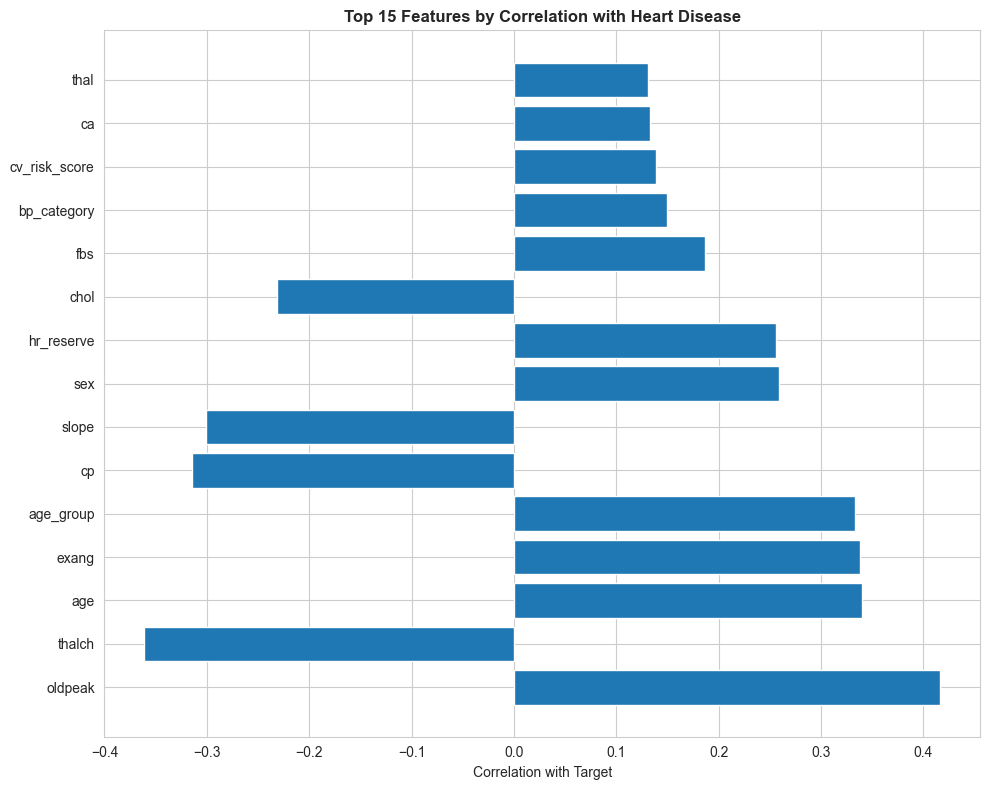

In [20]:
# Correlation with target
feature_target_corr = pd.DataFrame({
    'feature': X_engineered.columns,
    'correlation': [X_engineered[col].corr(y) for col in X_engineered.columns]
}).sort_values('correlation', key=abs, ascending=False)

print("Top 15 Features by Correlation with Target:")
print(feature_target_corr.head(15))

# Visualize top correlations
plt.figure(figsize=(10, 8))
top_features = feature_target_corr.head(15)
plt.barh(top_features['feature'], top_features['correlation'])
plt.xlabel('Correlation with Target')
plt.title('Top 15 Features by Correlation with Heart Disease', fontweight='bold')
plt.tight_layout()
plt.show()

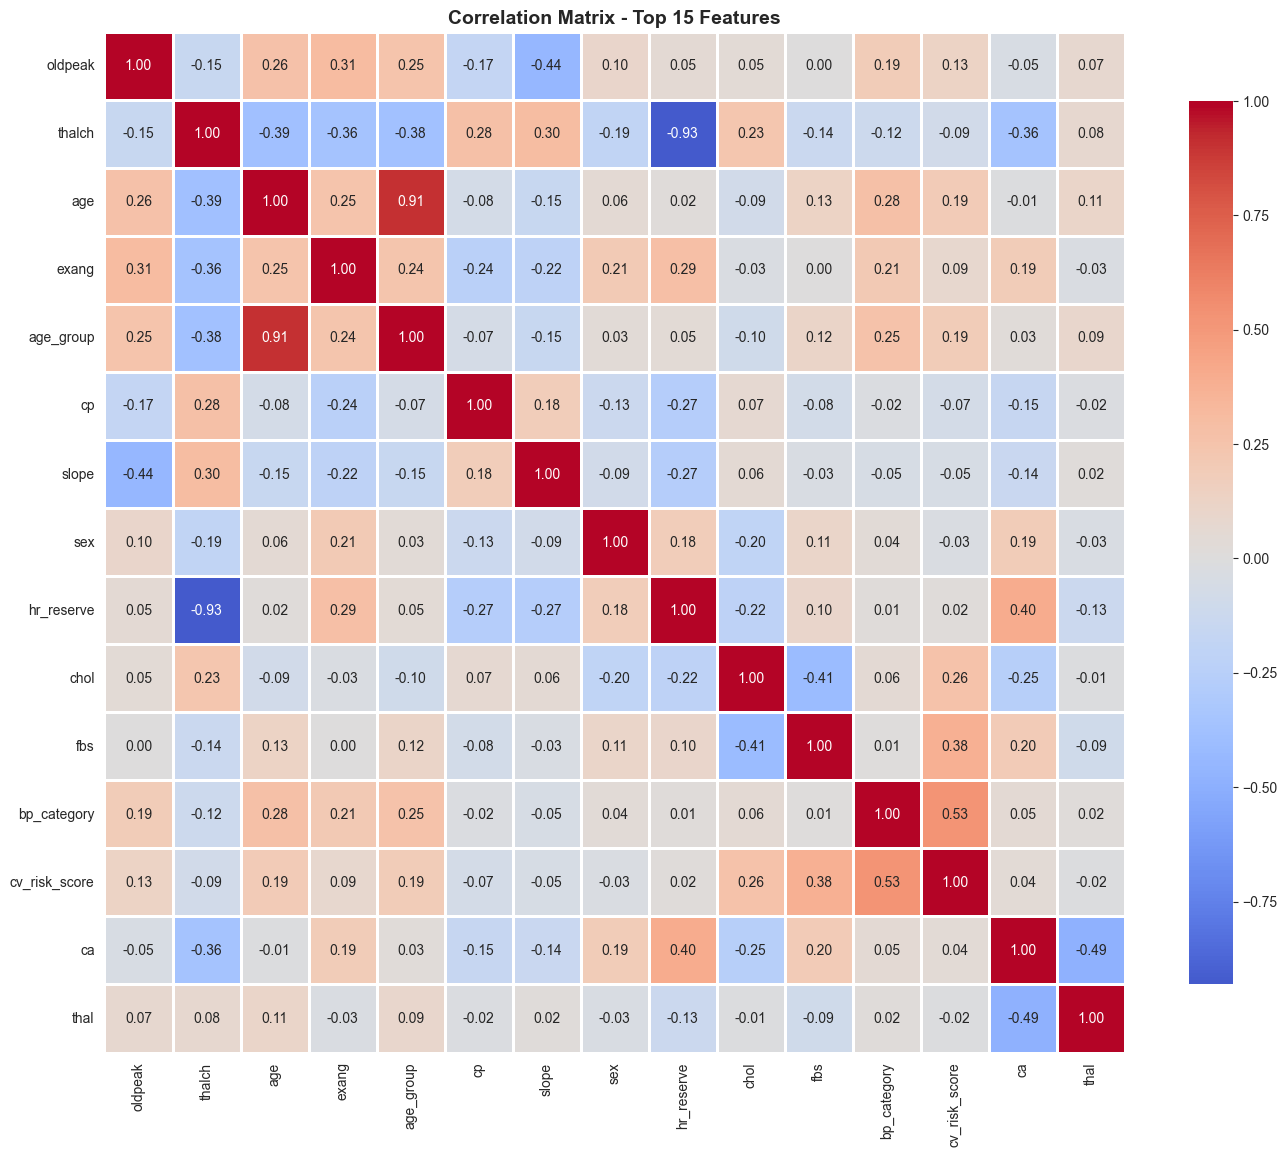

In [21]:
# Correlation matrix for top features
top_15_features = feature_target_corr.head(15)['feature'].tolist()
corr_matrix = X_engineered[top_15_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Top 15 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Prepare Datasets for Binary and Multi-class Classification

In [22]:
# Create binary target (0 = no disease, 1 = disease)
y_binary = (y > 0).astype(int)

print("Binary Target Distribution:")
print(y_binary.value_counts())
print(f"\nClass balance: {y_binary.value_counts()[0]/len(y_binary)*100:.1f}% / {y_binary.value_counts()[1]/len(y_binary)*100:.1f}%")

print("\nMulti-class Target Distribution:")
print(y.value_counts().sort_index())

Binary Target Distribution:
num
1    509
0    411
Name: count, dtype: int64

Class balance: 44.7% / 55.3%

Multi-class Target Distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


In [23]:
# Split data - stratified to maintain class distribution
# Binary classification split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_engineered, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Multi-class classification split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

print("Binary Classification Split:")
print(f"Train: {X_train_bin.shape}, Test: {X_test_bin.shape}")
print(f"Train target distribution: {y_train_bin.value_counts().to_dict()}")
print(f"Test target distribution: {y_test_bin.value_counts().to_dict()}")

print("\nMulti-class Classification Split:")
print(f"Train: {X_train_multi.shape}, Test: {X_test_multi.shape}")
print(f"Train target distribution: {y_train_multi.value_counts().sort_index().to_dict()}")
print(f"Test target distribution: {y_test_multi.value_counts().sort_index().to_dict()}")

Binary Classification Split:
Train: (736, 18), Test: (184, 18)
Train target distribution: {1: 407, 0: 329}
Test target distribution: {1: 102, 0: 82}

Multi-class Classification Split:
Train: (736, 18), Test: (184, 18)
Train target distribution: {0: 329, 1: 212, 2: 87, 3: 86, 4: 22}
Test target distribution: {0: 82, 1: 53, 2: 22, 3: 21, 4: 6}


## 8. Feature Scaling

In [24]:
# Standardize features (important for SVM and other algorithms)
scaler = StandardScaler()

# Fit on training data only to prevent data leakage
X_train_bin_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_bin),
    columns=X_train_bin.columns,
    index=X_train_bin.index
)

X_test_bin_scaled = pd.DataFrame(
    scaler.transform(X_test_bin),
    columns=X_test_bin.columns,
    index=X_test_bin.index
)

# Use same scaler for multi-class (same features)
X_train_multi_scaled = pd.DataFrame(
    scaler.transform(X_train_multi),
    columns=X_train_multi.columns,
    index=X_train_multi.index
)

X_test_multi_scaled = pd.DataFrame(
    scaler.transform(X_test_multi),
    columns=X_test_multi.columns,
    index=X_test_multi.index
)

print("Scaling completed!")
print(f"\nScaled feature statistics (train set):")
print(X_train_bin_scaled.describe())

Scaling completed!

Scaled feature statistics (train set):
                age           sex            cp      trestbps          chol  \
count  7.360000e+02  7.360000e+02  7.360000e+02  7.360000e+02  7.360000e+02   
mean   3.632360e-16  8.930055e-17  5.551115e-17 -1.323217e-15  1.158494e-16   
std    1.000680e+00  1.000680e+00  1.000680e+00  1.000680e+00  1.000680e+00   
min   -2.734186e+00 -1.904975e+00 -8.275708e-01 -2.909483e+00 -1.853271e+00   
25%   -7.041962e-01  5.249412e-01 -8.275708e-01 -6.877110e-01 -2.234212e-01   
50%    4.369471e-02  5.249412e-01 -8.275708e-01 -1.322680e-01  2.001555e-01   
75%    6.847440e-01  5.249412e-01  1.258361e+00  4.231750e-01  6.053159e-01   
max    2.501050e+00  5.249412e-01  2.301327e+00  3.755833e+00  3.699268e+00   

                fbs       restecg        thalch         exang       oldpeak  \
count  7.360000e+02  7.360000e+02  7.360000e+02  7.360000e+02  7.360000e+02   
mean  -2.896234e-17  7.240585e-17  1.930823e-16 -3.378940e-17  3.378940

## 9. Save Processed Data and Preprocessing Artifacts

In [25]:
# Save binary classification datasets
X_train_bin_scaled.to_csv('../data/processed/X_train_binary.csv', index=False)
X_test_bin_scaled.to_csv('../data/processed/X_test_binary.csv', index=False)
y_train_bin.to_csv('../data/processed/y_train_binary.csv', index=False)
y_test_bin.to_csv('../data/processed/y_test_binary.csv', index=False)

# Save multi-class classification datasets
X_train_multi_scaled.to_csv('../data/processed/X_train_multiclass.csv', index=False)
X_test_multi_scaled.to_csv('../data/processed/X_test_multiclass.csv', index=False)
y_train_multi.to_csv('../data/processed/y_train_multiclass.csv', index=False)
y_test_multi.to_csv('../data/processed/y_test_multiclass.csv', index=False)

# Save preprocessing artifacts for deployment
preprocessing_artifacts = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'knn_imputer': knn_imputer,
    'feature_names': X_engineered.columns.tolist(),
    'numeric_features': numeric_features,
    'categorical_features': categorical_features
}

with open('../data/processed/preprocessing_artifacts.pkl', 'wb') as f:
    pickle.dump(preprocessing_artifacts, f)

print("All datasets and artifacts saved successfully!")
print(f"\nSaved files:")
print("Binary Classification:")
print("  - X_train_binary.csv, X_test_binary.csv")
print("  - y_train_binary.csv, y_test_binary.csv")
print("\nMulti-class Classification:")
print("  - X_train_multiclass.csv, X_test_multiclass.csv")
print("  - y_train_multiclass.csv, y_test_multiclass.csv")
print("\nPreprocessing Artifacts:")
print("  - preprocessing_artifacts.pkl")

All datasets and artifacts saved successfully!

Saved files:
Binary Classification:
  - X_train_binary.csv, X_test_binary.csv
  - y_train_binary.csv, y_test_binary.csv

Multi-class Classification:
  - X_train_multiclass.csv, X_test_multiclass.csv
  - y_train_multiclass.csv, y_test_multiclass.csv

Preprocessing Artifacts:
  - preprocessing_artifacts.pkl


## 10. Summary Statistics

In [26]:
print("="*60)
print("DATA PREPROCESSING SUMMARY")
print("="*60)
print(f"\nOriginal dataset: {df.shape}")
print(f"After cleaning: {df_clean.shape}")
print(f"Final feature set: {X_engineered.shape}")
print(f"\nFeatures created: {X_engineered.shape[1]}")
print(f"Original features: {len(numeric_features) + len(categorical_features)}")
print(f"Engineered features: {X_engineered.shape[1] - (len(numeric_features) + len(categorical_features))}")

print(f"\n{'='*60}")
print("DATASET SPLITS")
print(f"{'='*60}")
print(f"\nBinary Classification:")
print(f"  Training samples: {len(X_train_bin)} ({len(X_train_bin)/len(X_engineered)*100:.1f}%)")
print(f"  Testing samples: {len(X_test_bin)} ({len(X_test_bin)/len(X_engineered)*100:.1f}%)")
print(f"  Features: {X_train_bin.shape[1]}")

print(f"\nMulti-class Classification:")
print(f"  Training samples: {len(X_train_multi)} ({len(X_train_multi)/len(X_engineered)*100:.1f}%)")
print(f"  Testing samples: {len(X_test_multi)} ({len(X_test_multi)/len(X_engineered)*100:.1f}%)")
print(f"  Features: {X_train_multi.shape[1]}")
print(f"  Classes: {len(y.unique())} (0-4)")

print(f"\n{'='*60}")
print("Ready for model training!")
print(f"{'='*60}")

DATA PREPROCESSING SUMMARY

Original dataset: (920, 16)
After cleaning: (920, 16)
Final feature set: (920, 18)

Features created: 18
Original features: 13
Engineered features: 5

DATASET SPLITS

Binary Classification:
  Training samples: 736 (80.0%)
  Testing samples: 184 (20.0%)
  Features: 18

Multi-class Classification:
  Training samples: 736 (80.0%)
  Testing samples: 184 (20.0%)
  Features: 18
  Classes: 5 (0-4)

Ready for model training!
